Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance segmentation performance evaluation and sample characterization

In this example we will do the following:

  * Evaluate how well the predicted masks agree with the hand-drawn annotations
  * Perform basic sample measurements (ie particle size)
  * Match satellites to particles to measure the satellite content of samples
 
 
## Note: 
We lump the predictions on training images with the validation images. This is because our available data so far is very limited, so we just 
want to show the process for analyzing the results. The process is exactly the same for analyzing larger quantities of data, so after generating predictions
you can replace the filepath with more validation or even unlabeled images to get a better representation of the performance of the model.

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pickle
import pycocotools.mask as RLE
import seaborn as sns
import skimage
import skimage.io

ampis_root = str(Path('..','..'))
import sys
if ampis_root not in sys.path:
    sys.path.append(ampis_root)

from ampis import analyze, data_utils
from ampis.applications import powder
from ampis.structures import InstanceSet
from ampis.visualize import display_iset

%matplotlib inline

# Calculating Geometric Segmentation Results


gt filename: S08_03_SE1_1000X03.png	 pred filename: S08_03_SE1_1000X03.png
gt filename: S06_01_SE1_500X67.png	 pred filename: S06_01_SE1_500X67.png
gt filename: S04_02_SE1_1000X50.png	 pred filename: S04_02_SE1_1000X50.png
gt filename: S03_03_SE1_1250X41.png	 pred filename: S03_03_SE1_1250X41.png
gt filename: S02_01_SE1_300X14.png	 pred filename: S02_01_SE1_300X14.png
gt filename: HP743_2S_250x.png	 pred filename: HP743_2S_250x.png
x:  [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
y:  [0.25, 0.1, 0.16, 0.33, 0.25, 0.22, 0.7, 0.48, 0.76, 0.74, 0.63, 0.78]
Average Precision Score:  0.21804671631685849
Average Precision Score:  0.6814140826045588
Precision: 0.07257311064183784
Recall: 0.6849257156661432
---
Precision: 0.03232688205108493
Recall: 0.46259625962596257
---
Precision: 0.06037541121073341
Recall: 0.7975290233251677
---
Precision: 0.10801750427153249
Recall: 0.6469064375458745
---
Precision: 0.052041593699603254
Recall: 0.4695590073201214
---
Precision: 0.061496551946032325
Recall: 0.700

KeyboardInterrupt: 

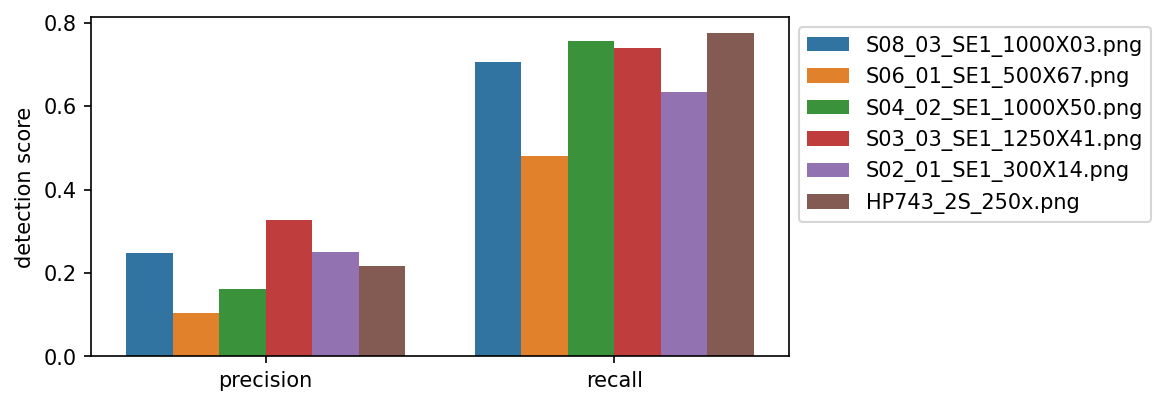

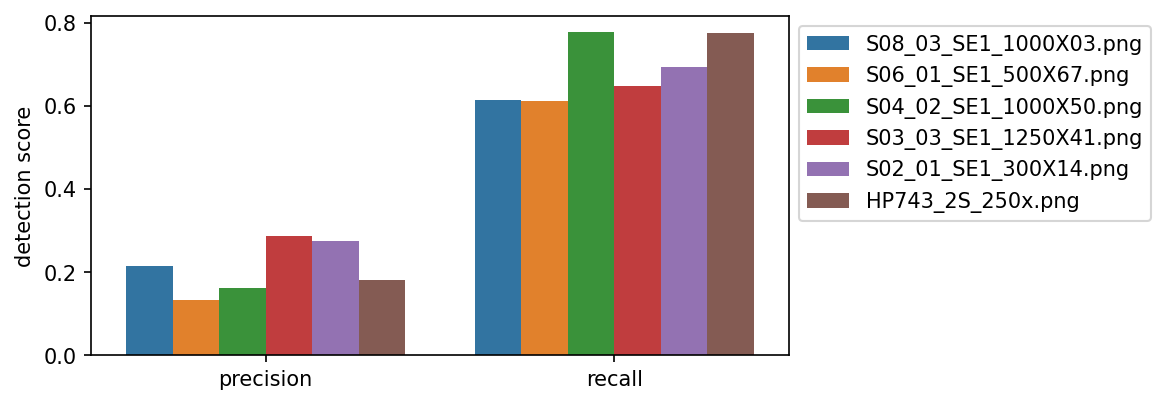

In [10]:
average_p = []
average_r = []
for i in range(1,17):
    #Loading Ground Truth Labels
    satellites_gt_path = Path('..', 'validating', 'satellite_auto_validation_v1.2.json')
    for path in [satellites_gt_path]:
        assert path.is_file(), f'File not found : {path}'
    satellites_gt_dd = data_utils.get_ddicts('via2', satellites_gt_path, dataset_class='train')
    #Loading Prediction Labels
    satellites_path = Path('geometric_training_results', f'satellite-stage-transformation-{i}.pickle')
    assert satellites_path.is_file()
    with open(satellites_path, 'rb') as f:
        satellites_pred = pickle.load(f)
    iset_satellites_gt = [InstanceSet().read_from_ddict(x, inplace=False) for x in satellites_gt_dd]
    iset_satellites_pred = [InstanceSet().read_from_model_out(x, inplace=False) for x in satellites_pred]
    #Creating Instance Set Objects
    iset_satellites_gt, iset_satellites_pred = analyze.align_instance_sets(iset_satellites_gt, iset_satellites_pred)
    #Re-ordering instance sets to be concurrent
    for gt, pred in zip(iset_satellites_gt, iset_satellites_pred):
        pred.HFW = gt.HFW
        pred.HFW_units = gt.HFW_units
        print(f'gt filename: {Path(gt.filepath).name}\t pred filename: {Path(pred.filepath).name}')
    #Creating Detection Scores
    dss_satellites = [analyze.det_seg_scores(gt, pred, size=gt.instances.image_size)
                     for gt, pred in zip(iset_satellites_gt, iset_satellites_pred)]
    labels = []
    counts = {'train': 0, 'validation': 0}
    for iset in iset_satellites_gt:
        counts[iset.dataset_class] += 1
        labels.append(iset.filepath.name)
    x=[*([1] * len(labels)), *([2] * len(labels))]
    # y values are the bar heights

    scores = [*[x['det_precision'] for x in dss_satellites],
         *[x['det_recall'] for x in dss_satellites]]
    labels = labels * 2
    print('x: ', x)
    print('y: ', [np.round(x, decimals=2) for x in scores])
    #print('labels: ', labels)
    fig, ax = plt.subplots(figsize=(6,3), dpi=150)
    sns.barplot(x=x, y=scores, hue=labels, ax=ax)
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel('detection score')
    ax.set_xticklabels(['precision','recall'])
    print("Average Precision Score: ", str(sum([*[x['det_precision'] for x in dss_satellites]])/len([*[x['det_precision'] for x in dss_satellites]])))
    print("Average Precision Score: ", str(sum([*[x['det_recall'] for x in dss_satellites]])/len([*[x['det_recall'] for x in dss_satellites]])))
    #Analyzing Prediction Scores on a pixel level
    temp_p = []
    temp_r = []
    total_area = 1024*768
    for instance in range(len(iset_satellites_pred)):
        fp_area = 0
        fn_area = 0
        tp_area = 0
        iset_satellites_pred[instance].compute_rprops(keys=['area'])
        for i in dss_satellites[instance]['det_fp']:
            try: 
                fp_area += int(iset_satellites_pred[instance].rprops['area'][i])
            except:
                pass

        for i in dss_satellites[instance]['det_fn']:
            try: 
                fn_area += int(iset_satellites_pred[instance].rprops['area'][i])
            except:
                pass

        #print(dss_satellites[0]['seg_tp'])
        for i in dss_satellites[instance]['det_tp']:
            try: 
                tp_area += int(iset_satellites_pred[instance].rprops['area'][i[1]])
            except:
                pass
        print("Precision:", str(tp_area/(tp_area+fp_area)))
        print('Recall:', str(tp_area/(tp_area+fn_area)))
        temp_p.append(tp_area/(tp_area+fp_area))
        temp_r.append(tp_area/(tp_area+fn_area))
        print('---')
    average_p.append(temp_p)
    average_r.append(temp_r)
    counter = 0   
    for iset in iset_satellites_gt:
        gt = iset_satellites_gt[counter]
        pred = iset_satellites_pred[counter]
        iset_det, colormap = analyze.det_perf_iset(gt, pred)
        img = skimage.color.gray2rgb(skimage.io.imread(iset.filepath))
        #display_iset(img, iset=iset_det)
        counter += 1
        


In [6]:
S08_1000 = []
S06_500 = []
S04_1000 = []
S03_1250 = []
S02_300 = []
HP_250 = []
for i in range(len(average_p)):
    S08_1000.append([i, average_p[i][0]])
    S06_500.append([i, average_p[i][1]])
    S04_1000.append([i, average_p[i][2]])
    S03_1250.append([i, average_p[i][3]])
    S02_300.append([i, average_p[i][4]])
    HP_250.append([i, average_p[i][5]])
print(S03_1250)

[[0, 0.10801750427153249], [1, 0.024854451557996943], [2, 0.20811204326423074], [3, 0.09020689832590506], [4, 0.19613391231264882], [5, 0.330550120580607], [6, 0.24368591287592045], [7, 0.061398730841957495], [8, 0.3576603750116608], [9, 0.5731139733737417], [10, 0.44612586395052745], [11, 0.4237345713962179], [12, 0.6174641036434217], [13, 0.47799132052076876], [14, 0.5583157314721279], [15, 0.5583157314721279]]


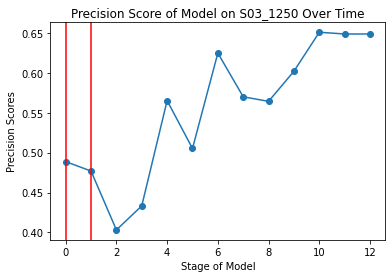

In [24]:
plt.title("Precision Score of Model on S03_1250 Over Time")
xyz = np.array(S03_1250)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(0, c='r')
plt.axvline(1, c='r')
print('')

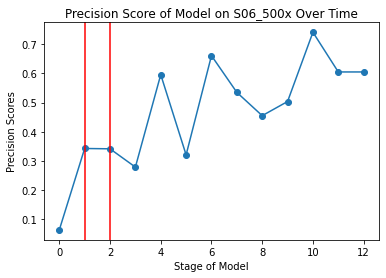

In [25]:
plt.title("Precision Score of Model on S06_500x Over Time")
xyz = np.array(S06_500)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(1, c='r')
plt.axvline(2, c='r')
print('')

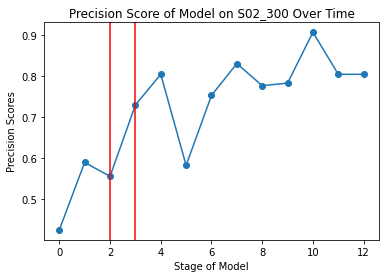

In [26]:
plt.title("Precision Score of Model on S02_300 Over Time")
xyz = np.array(S02_300)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(2, c='r')
plt.axvline(3, c='r')
print('')

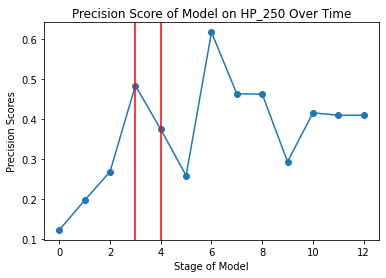

In [27]:
plt.title("Precision Score of Model on HP_250 Over Time")
xyz = np.array(HP_250)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(3, c='r')
plt.axvline(4, c='r')
print('')

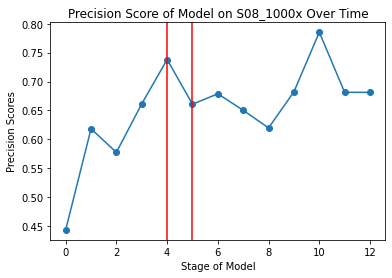

In [28]:
plt.title("Precision Score of Model on S08_1000x Over Time")
xyz = np.array(S08_1000)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(4, c='r')
plt.axvline(5, c='r')
print('')

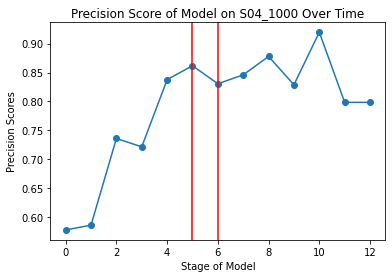

In [29]:
plt.title("Precision Score of Model on S04_1000 Over Time")
xyz = np.array(S04_1000)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(5, c='r')
plt.axvline(6, c='r')
print('')

[0.4432934452580818, 0.06275468622656886, 0.5778993435448577, 0.48875663612078585, 0.42542721358994234, 0.12317327766179541]
[0.681294452347084, 0.6049510056730273, 0.7984940252087085, 0.6485376389774096, 0.8040017851829813, 0.4091381931663599]
[0.6380790786158671, 0.49735281660313424, 0.9134194143417108, 0.6253352946266332, 0.5837572842475257, 0.49590381955527185]
[0.657582206356834, 0.4395453409942543, 0.6919148936170213, 0.5544254752391331, 0.6940413509695647, 0.7519117647058824]
Initial Model Precision: 0.35355076706700533
Final Model Precision: 0.6577361834259284
Initial Model Recall: 0.6256412846650238
Final Model Recall: 0.6315701719804482
0.12317327766179541
0.1969575660528423
0.26841346455212184
0.48286808976464146
0.37409247229652276
0.25854858548585485
0.6160051216389244
0.4624169435215947
0.46173738147687005
0.2931770363691013
0.4149879970775493
0.4091381931663599
0.4091381931663599
Initial Model Precision: 0.3996262649480473
Final Model Precision: 0.7074557814778422
Initia

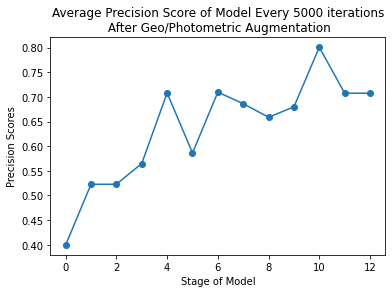

In [30]:
print(average_p[0])
print(average_p[-1])
print(average_r[0])
print(average_r[-1])
print("Initial Model Precision:", str(sum(average_p[0])/len(average_p[0])))
print("Final Model Precision:", str(sum(average_p[-1])/len(average_p[-1])))
print("Initial Model Recall:", str(sum(average_r[0])/len(average_r[0])))
print("Final Model Recall:", str(sum(average_r[-1])/len(average_r[-1])))
altered_average_p = []
altered_average_r = []
for i in average_p:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_p.append(temp)
for i in average_r:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_r.append(temp)
for i in range(len(altered_average_p)):
    print(altered_average_p[i].pop(-1))
for i in range(len(altered_average_r)):
    altered_average_r[i].pop(-1)
#print(altered_average_r)
print("Initial Model Precision:", str(sum(altered_average_p[0])/len(altered_average_p[0])))
print("Final Model Precision:", str(sum(altered_average_p[-1])/len(altered_average_p[-1])))
print("Initial Model Recall:", str(sum(altered_average_r[0])/len(altered_average_r[0])))
print("Final Model Recall:", str(sum(altered_average_r[-1])/len(altered_average_r[-1])))    
ave_p = []
ave_r = []
for i in range(len(altered_average_p)):
    ave_p.append([i, sum(altered_average_p[i])/len(altered_average_p[i])])
for i in range(len(altered_average_r)):
    ave_r.append([i, sum(altered_average_r[i])/len(altered_average_r[i])])
print(ave_p)
plt.title("Average Precision Score of Model Every 5000 iterations\n After Geo/Photometric Augmentation")
xyz = np.array(ave_p)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])

[0.07257311064183784, 0.03232688205108493, 0.06037541121073341, 0.10801750427153249, 0.052041593699603254, 0.061496551946032325]
[0.566160287723442, 0.38814745683621094, 0.7667332142481874, 0.5583157314721279, 0.5204303472880316, 0.2196733345567994]
[0.6849257156661432, 0.46259625962596257, 0.7975290233251677, 0.6469064375458745, 0.4695590073201214, 0.7008923114533676]
[0.564372859589041, 0.5081867057673509, 0.7332194533762058, 0.5246149199637572, 0.47422156753187383, 0.30214556163230966]
Initial Model Precision: 0.06447184230347071
Final Model Precision: 0.5032433953541332
Initial Model Recall: 0.6270681258227728
Final Model Recall: 0.5177935113100897
0.061496551946032325
0.017885614399424907
0.14749066352893028
0.09674205651058779
0.09203085700781553
0.24002860758100897
0.15152730432457723
0.07424176963622224
0.17360082069987462
0.27842511958788174
0.18440779610194902
0.13444945267224725
0.20667063728409768
0.2922256938062856
0.2196733345567994
0.2196733345567994
Initial Model Precis

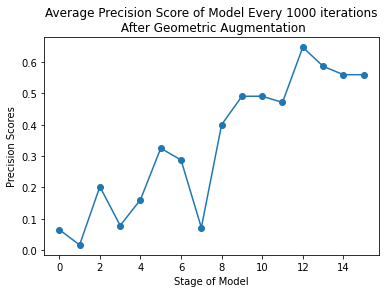

In [8]:
print(average_p[0])
print(average_p[-1])
print(average_r[0])
print(average_r[-1])
print("Initial Model Precision:", str(sum(average_p[0])/len(average_p[0])))
print("Final Model Precision:", str(sum(average_p[-1])/len(average_p[-1])))
print("Initial Model Recall:", str(sum(average_r[0])/len(average_r[0])))
print("Final Model Recall:", str(sum(average_r[-1])/len(average_r[-1])))
altered_average_p = []
altered_average_r = []
for i in average_p:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_p.append(temp)
for i in average_r:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_r.append(temp)
for i in range(len(altered_average_p)):
    print(altered_average_p[i].pop(-1))
for i in range(len(altered_average_r)):
    altered_average_r[i].pop(-1)
#print(altered_average_r)
print("Initial Model Precision:", str(sum(altered_average_p[0])/len(altered_average_p[0])))
print("Final Model Precision:", str(sum(altered_average_p[-1])/len(altered_average_p[-1])))
print("Initial Model Recall:", str(sum(altered_average_r[0])/len(altered_average_r[0])))
print("Final Model Recall:", str(sum(altered_average_r[-1])/len(altered_average_r[-1])))    
ave_p = []
ave_r = []
for i in range(len(altered_average_p)):
    ave_p.append([i, sum(altered_average_p[i])/len(altered_average_p[i])])
for i in range(len(altered_average_r)):
    ave_r.append([i, sum(altered_average_r[i])/len(altered_average_r[i])])
print(ave_p)
plt.title("Average Precision Score of Model Every 1000 iterations\n After Geometric Augmentation")
xyz = np.array(ave_p)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])

[0.07257311064183784, 0.03232688205108493, 0.06037541121073341, 0.10801750427153249, 0.052041593699603254, 0.061496551946032325]
[0.566160287723442, 0.38814745683621094, 0.7667332142481874, 0.5583157314721279, 0.5204303472880316, 0.2196733345567994]
[0.6849257156661432, 0.46259625962596257, 0.7975290233251677, 0.6469064375458745, 0.4695590073201214, 0.7008923114533676]
[0.564372859589041, 0.5081867057673509, 0.7332194533762058, 0.5246149199637572, 0.47422156753187383, 0.30214556163230966]
Initial Model Precision: 0.06447184230347071
Final Model Precision: 0.5032433953541332
Initial Model Recall: 0.6270681258227728
Final Model Recall: 0.5177935113100897
0.061496551946032325
0.017885614399424907
0.14749066352893028
0.09674205651058779
0.09203085700781553
0.24002860758100897
0.15152730432457723
0.07424176963622224
0.17360082069987462
0.27842511958788174
0.18440779610194902
0.13444945267224725
0.20667063728409768
0.2922256938062856
0.2196733345567994
0.2196733345567994
Initial Model Precis

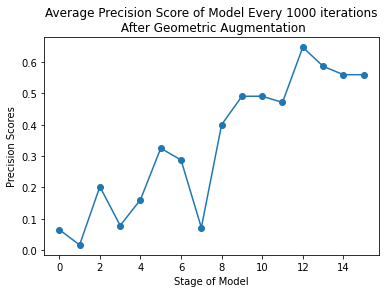

In [8]:
print(average_p[0])
print(average_p[-1])
print(average_r[0])
print(average_r[-1])
print("Initial Model Precision:", str(sum(average_p[0])/len(average_p[0])))
print("Final Model Precision:", str(sum(average_p[-1])/len(average_p[-1])))
print("Initial Model Recall:", str(sum(average_r[0])/len(average_r[0])))
print("Final Model Recall:", str(sum(average_r[-1])/len(average_r[-1])))
altered_average_p = []
altered_average_r = []
for i in average_p:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_p.append(temp)
for i in average_r:
    temp = []
    for j in i:
        temp.append(j)
    altered_average_r.append(temp)
for i in range(len(altered_average_p)):
    print(altered_average_p[i].pop(-1))
for i in range(len(altered_average_r)):
    altered_average_r[i].pop(-1)
#print(altered_average_r)
print("Initial Model Precision:", str(sum(altered_average_p[0])/len(altered_average_p[0])))
print("Final Model Precision:", str(sum(altered_average_p[-1])/len(altered_average_p[-1])))
print("Initial Model Recall:", str(sum(altered_average_r[0])/len(altered_average_r[0])))
print("Final Model Recall:", str(sum(altered_average_r[-1])/len(altered_average_r[-1])))    
ave_p = []
ave_r = []
for i in range(len(altered_average_p)):
    ave_p.append([i, sum(altered_average_p[i])/len(altered_average_p[i])])
for i in range(len(altered_average_r)):
    ave_r.append([i, sum(altered_average_r[i])/len(altered_average_r[i])])
print(ave_p)
plt.title("Average Precision Score of Model Every 1000 iterations\n After Geometric Augmentation")
xyz = np.array(ave_p)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])

## Visualize segmentation results for powder

Segmentation results indicate how well each matched pair of masks agrees. True positives (included in both gt and pred masks) are shown in purple, false positive pixels (included in pred but not gt) are shown in blue, and false negative pixels (included in gt but not pred) are shown in red.

Detectron2 appears to smooth out masks, which can affect the display of discontinuous masks here. This can affect the display of the mask visualization, so we pass apply_correction=True to prevent this.

In [10]:
iset_seg, (colors, color_labels) = analyze.seg_perf_iset(gt, pred,)
#display_iset(img, iset=iset_seg, apply_correction=True)

## Visualize match results for satellites
The process above can be repeated exactl to analyze the satellite results.

In [11]:
# select instances for the same image
gt_s, pred_s = [(x, y) for x, y in zip(iset_satellites_gt, iset_satellites_pred) if str(x.filepath) == pred.filepath][0]

iset_det_s, colormap_s = analyze.det_perf_iset(gt_s, pred_s)


#display_iset(img, iset=iset_det_s)

# Powder Characterization- Size Distribution

Once we have the masks it is pretty trivial to compute various properties. With binary masks we can use [skimage regionprops] (https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops), which provides many convenient measurements out of the box. If there are any additional measurements you need, you can also access the masks directly and define your own methods. 

In [16]:
for iset in [*iset_particles_gt, *iset_particles_pred]:
    if iset.rprops is None:  # avoid re-computing regionprops if cell has already been run
        iset.compute_rprops()  # since rprops requires the masks to be uncompressed, this takes a bit longer to run
iset_particles_pred[-1].rprops.head()

,area,equivalent_diameter,major_axis_length,perimeter,solidity,orientation,class_idx
0,[311],[19.899183360445615],[20.639755859773054],[64.38477631085023],[0.9779874213836478],[1.5081004926051413],0
1,[4542],[76.04639381448084],[81.22474446954983],[253.4802307403552],[0.9822664359861591],[0.3191718231023808],0
2,[4698],[77.3413174258481],[114.33466956433317],[320.2497833620557],[0.7870665103032334],[0.5126964985555602],0
3,[3591],[67.61806862920568],[72.03116476057895],[233.09545442950497],[0.9452487496709661],[0.6646659488117915],0
4,[12471],[126.01019943795112],[129.3545748721626],[418.91883092036784],[0.985382427307206],[-1.2422986885762402],0


Note that the measurements are in terms of pixels. If the conversion for pixels to microns is known, then we can generate equivalent measurements.

ground truth PSD


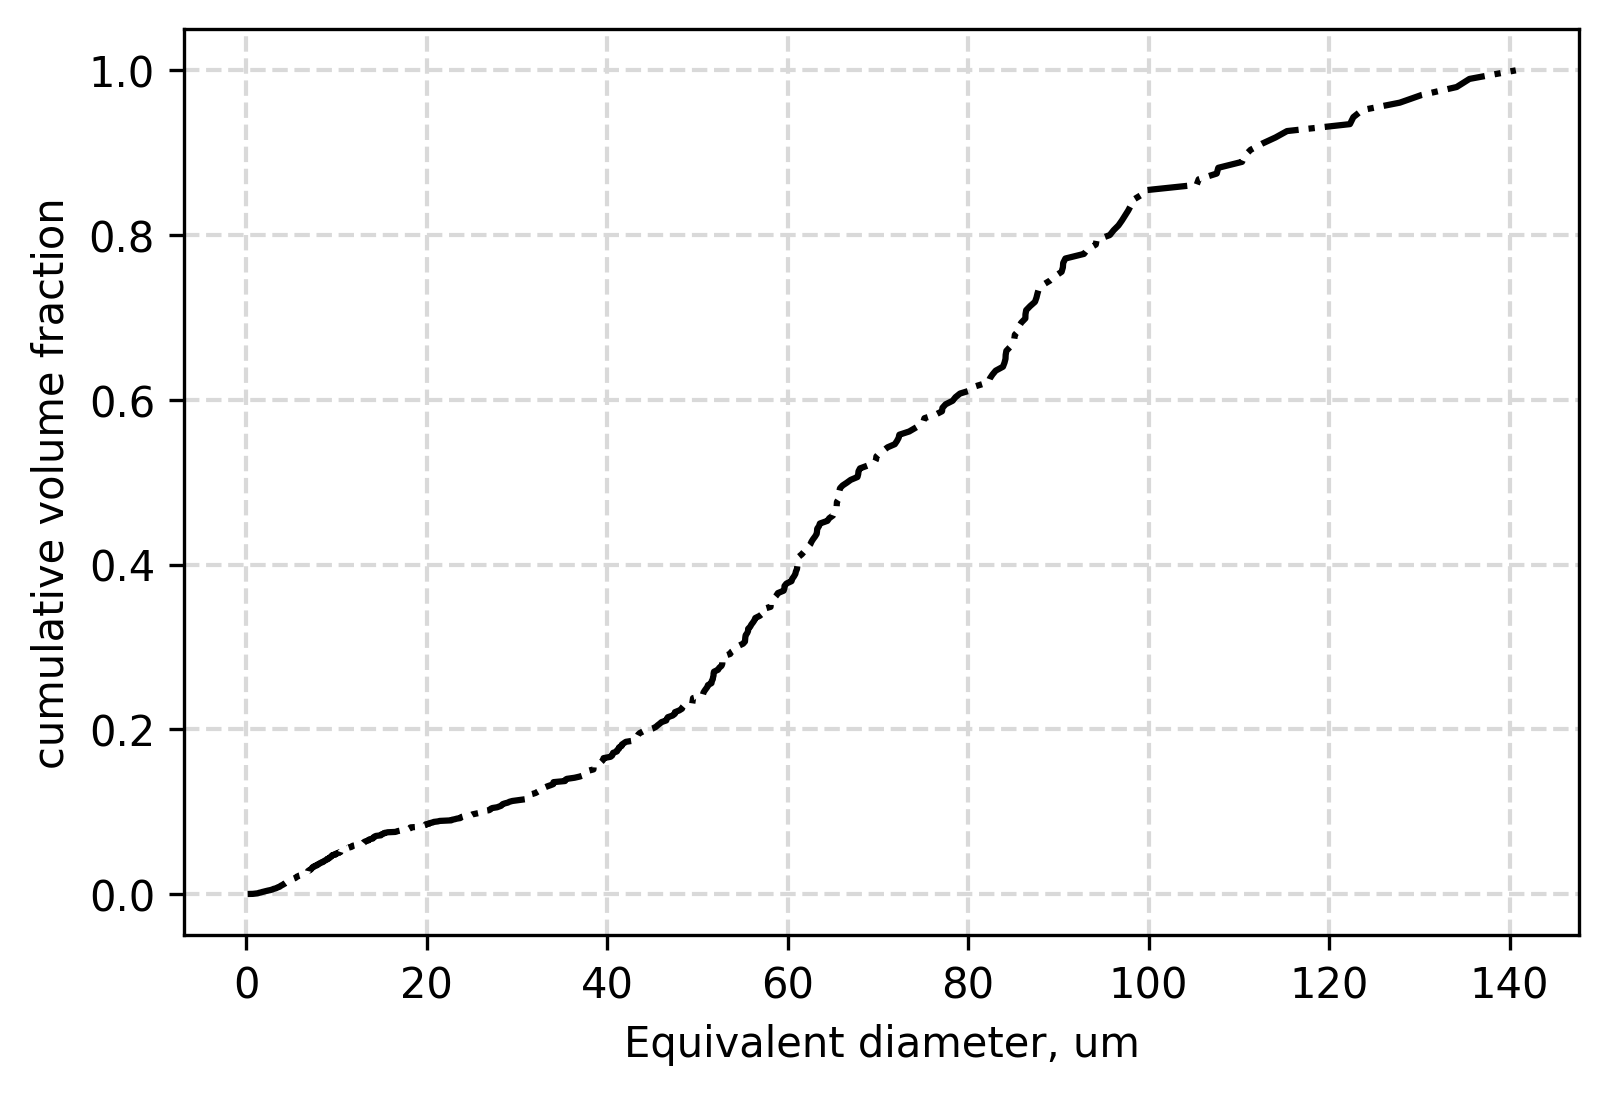

predicted PSD


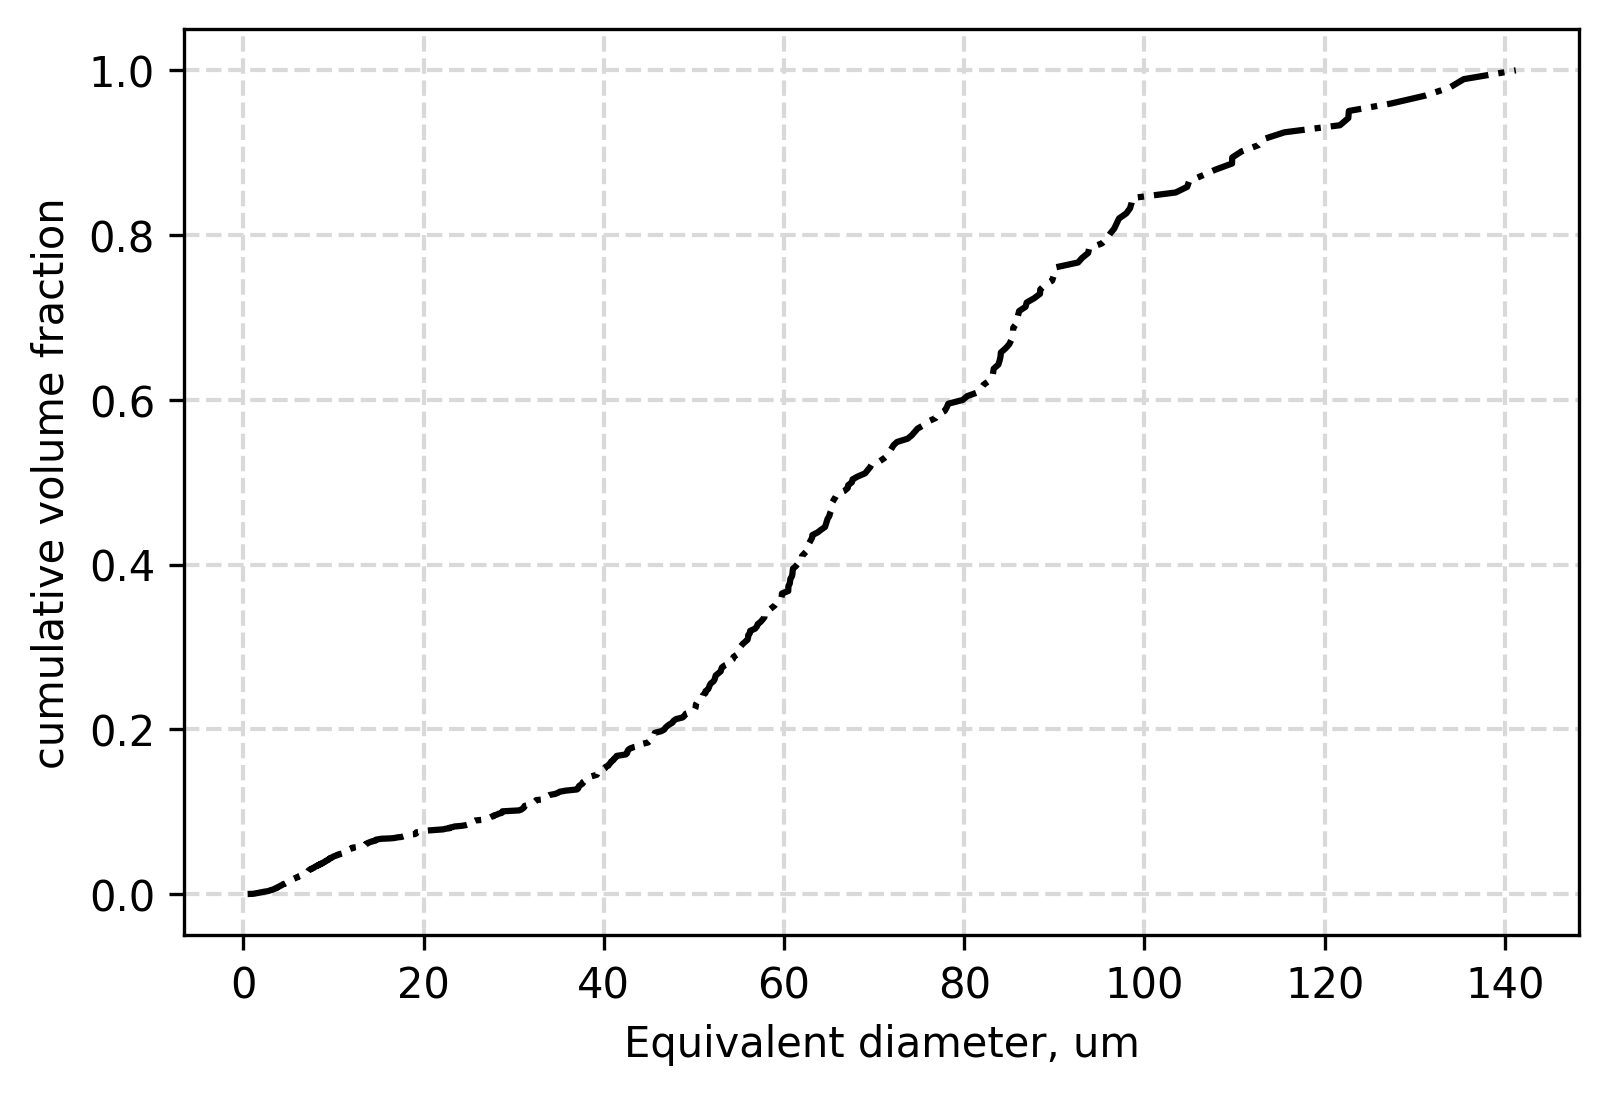

In [17]:
print('ground truth PSD')
areas_gt = powder.psd(iset_particles_gt)
print('predicted PSD')
areas_pred = powder.psd(iset_particles_pred)



# Satellite content measurements
The process here is fairly straightforward. We have masks for powder particles and masks for satellites. To match the satellites to their corresponding particles, we simply overlay the masks and look for intersections. Then, it is trivial to count the number of particles containing satellites. 



We have more labeled satellite images than particle images. We only want to keep images that have labels for both particles and satellites.
To help with the implementation, we can combine the masks for particles and satellites in the PowderSatelliteImage class

In [18]:
iset_particles_gt_ss, iset_satellites_gt_ss = analyze.align_instance_sets(iset_particles_gt, iset_satellites_gt)
iset_particles_pred_ss, iset_satellites_pred_ss = analyze.align_instance_sets(iset_particles_pred, iset_satellites_pred)
psi_gt = []
psi_pred = []
for pg, pp, sg, sp in zip(iset_particles_gt_ss, iset_particles_pred_ss, iset_satellites_gt_ss, iset_satellites_pred_ss):
    files = [Path(x).name for x in [pg.filepath, pp.filepath, sg.filepath, sp.filepath]]
    assert all([x == files[0] for x in files])  # the files are in the same order and there are no excess files
    psi_gt.append(powder.PowderSatelliteImage(particles=pg, satellites=sg))
    psi_pred.append(powder.PowderSatelliteImage(particles=pp, satellites=sp))


In [19]:
for gt, pred in zip(psi_gt, psi_pred):
    for psi in [gt, pred]:
        psi.compute_matches()

The matches for psi are stored in psi.matches as a dictionary. The key 'match_pairs' returns a dictionary whose keys are indices of particle masks that contain satellites. The value corresponding to each key is a list of indices of satellite masks that matched (note that multiple satellites can match with a single particle.)

Text(0.5, 1.0, 'predicted')

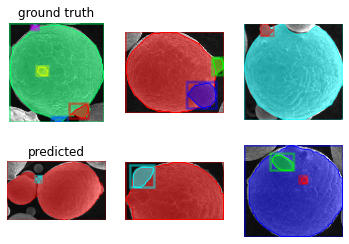

In [20]:
gt = psi_gt[0]
pred = psi_pred[0]

gt_idx = np.random.choice(list(gt.matches['match_pairs'].keys()), 3)
pred_idx = np.random.choice(list(pred.matches['match_pairs'].keys()), 3)

fig, ax = plt.subplots(2,3)


for i, (g, p) in enumerate(zip(gt_idx, pred_idx)):
    gt.visualize_particle_with_satellites(g, ax[0, i])
    pred.visualize_particle_with_satellites(p, ax[1, i])
ax[0,0].set_title('ground truth')
ax[1,0].set_title('predicted')

To compute the ratio of satellited particles, we can get the total number of 

## Final satellite measurements

The number of satellites in each set, fraction of satellited particles, and some other information can be displayed with one command.
The results can be printed directly, and are also returned

In [21]:
print('ground truth results')
results_gt = powder.satellite_measurements(psi_gt, print_summary=True, output_dict=True)
print('predicted results')
results_pred = powder.satellite_measurements(psi_pred, True, True)


ground truth results
number of images                   	5
number of particles                	1360
number of matched satellites       	585
number of unmatched satellites     	2
number of satellited particles     	315
fraction of satellited particles   	0.23161764705882354
median number of satellites per
satellited particle             	1.0
predicted results
number of images                   	5
number of particles                	1138
number of matched satellites       	403
number of unmatched satellites     	20
number of satellited particles     	269
fraction of satellited particles   	0.23637961335676624
median number of satellites per
satellited particle             	1.0


The results are (optionally) returned as a dictionary in case you need to store them for further analysis or post processing.

In [22]:
results_gt

{'n_images': 5,
 'n_particles': 1360,
 'n_satellites': 585,
 'n_satellites_unmatched': 2,
 'n_satellited_particels': 315,
 'sat_frac': 0.23161764705882354,
 'mspp': 1.0,
 'unique_satellites_per_particle': array([ 1,  2,  3,  4,  5,  6,  7, 14]),
 'counts_satellites_per_particle': array([0.53333333, 0.79047619, 0.9047619 , 0.96507937, 0.98095238,
        0.99047619, 0.9968254 , 1.        ])}